# Trabalho I

## Parte Teórica

*Faça uma descrição de como funcionam generalizações dos classificadores binários para o cenário multiclasse, para os classificadores que vimos até o momento. Mais especificamente, você deverá dizer como que cada um deles pode ser generalizado para problemas multiclasse (é naturalmente embutido em sua teoria? É necessário alguma técnica adicional? O que é OvO? O que é OvA?) Descreva também como que as métricas que vimos são generalizadas para o cenário multiclasse.*

## Parte Prática 

### Informação Básica

In [2]:
### Biblioteca

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from skimage.feature import hog
from skimage.morphology import reconstruction

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import metrics

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
### Dados

# Treino

feat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_images.csv', header = None)
resp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_labels.csv')

    # Eliminação de 40% das amostras
feat, feat_trash, resp, resp_trash = train_test_split(feat, resp, 
                                                      test_size=0.5, 
                                                      random_state=0, 
                                                      stratify=resp['Volcano?'])

# Teste

feat_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_images.csv', header = None)
resp_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_labels.csv')

FileNotFoundError: ignored

### Questão 1

*Prever, **somente a partir da imagem**, se naquela foto há ou não um vulcão. Ou seja, deve ser resolvido o problema de **classificação binária** onde os dados observados são as linhas do DataFrame ``feat`` e a variável resposta é a coluna ``Volcano?`` do DataFrame ``resp``.*

Para o pré-processamento optei pelo filtro que ressalta os picos das imagens seguido pelo histograma de gradiente orientado, esperando com que os vulcões na superfície de Vênus fiquem mais fáceis de serem detectados pelos classificadores.

In [ ]:
### Pré-processamento - Treino

hog_feat = []
hogfeat = pd.DataFrame(columns=range(0,110*110))

peak_feat = []
#peakfeat = pd.DataFrame(columns=range(0,110*110))


for i in feat:
    image_feat = np.array(feat.iloc[i]).reshape(110,110)
    
    # Peaks
    seed_min = np.copy(image_feat)
    seed_min[1:-1, 1:-1] = image_feat.min()
    
    mask = image_feat
    
    peak_feat = reconstruction(seed_min, mask, method='dilation')
    #peakfeat.loc[i,:] = peak_feat.reshape(1,110*110)
  
    # Histogram of Oriented Gradient
    hog_feat.append(hog(peak_feat, visualize=True)[1])
    hogfeat.loc[i,:] = hog_feat[i].reshape(1,110*110)



In [ ]:
### Pré-processamento - Teste

hog_feat_test = []
hogfeat_test = pd.DataFrame(columns=range(0,110*110))

peak_feat_test = []
#peakfeat_test = pd.DataFrame(columns=range(0,110*110))


for i in feat_test:
    image_feat_test = np.array(feat_test.iloc[i]).reshape(110,110)
    
    # Peaks
    seed_min_test = np.copy(image_feat_test)
    seed_min_test[1:-1, 1:-1] = image_feat_test.min()
    
    mask_test = image_feat_test
    
    peak_feat_test = reconstruction(seed_min_test, mask_test, method='dilation')
    #peakfeat_test.loc[i,:] = peak_feat_test.reshape(1,110*110)
    
    # Histogram of Oriented Gradient
    hog_feat_test.append(hog(peak_feat_test, visualize=True)[1])
    hogfeat_test.loc[i,:] = hog_feat_test[i].reshape(1,110*110)

In [6]:
#hogfeat.to_csv('/content/drive/MyDrive/Colab Notebooks/hogfeat.csv')
#hogfeat_test.to_csv('/content/drive/MyDrive/Colab Notebooks/hogfeat_test.csv')

hogfeat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hogfeat.csv')
hogfeat_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hogfeat_test.csv')

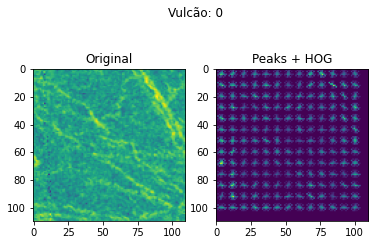

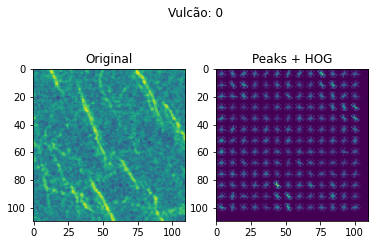

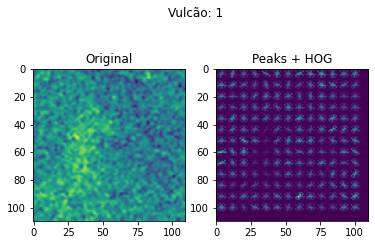

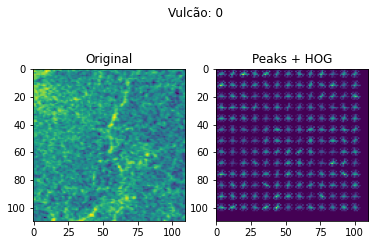

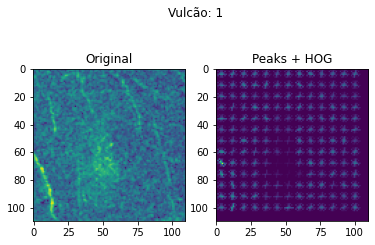

In [ ]:
# Plot

for i in range(0,5):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('Vulcão: ' + str(resp.iloc[i,0]))
    ax1.imshow(np.array(feat.iloc[i]).reshape(110,110))
    ax1.set_title('Original')
    ax2.imshow(hog_feat[i])
    ax2.set_title('Peaks + HOG')

#### Modelos

In [7]:
### Naive Bayes

model_nb = GaussianNB()


### LDA e QDA

model_lda = LinearDiscriminantAnalysis()
model_qda = QuadraticDiscriminantAnalysis()


### SVM

model_svm_lin = LinearSVC()
model_svm_pol = SVC(kernel='poly')
model_svm_rbf = SVC(kernel='rbf')

#### Cross Validation

In [32]:
### Cross-Validation - NB, LDA, QDA

scoring = {"AUC": metrics.make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_proba = True), 
           'F1': metrics.make_scorer(metrics.f1_score, greater_is_better = True, needs_proba = False)}

Score_nb = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
       cv1_nb = cross_val_score(model_nb, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
       cv2_nb = cross_val_score(model_nb, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
       Score_nb.iloc[i,:] = [cv1_nb.mean(), cv2_nb.mean()]
print('NB: ok')

Score_lda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
        cv1_lda = cross_val_score(model_lda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
        cv2_lda = cross_val_score(model_lda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
        Score_lda.iloc[i,:] = [cv1_lda.mean(), cv2_lda.mean()]
print('LDA: ok')

Score_qda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
      cv1_qda = cross_val_score(model_qda, X=feat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
      cv2_qda = cross_val_score(model_qda, X=hogfeat, y=resp.iloc[:,0], cv = 5,
                scoring = score)
      Score_qda.iloc[i,:] = [cv1_qda.mean(), cv2_qda.mean()]
print('QDA: ok') 

NB: ok
LDA: ok


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

QDA: ok


In [8]:
### Cross Validation - SVM linear

param_svm_lin = [{'C': [10, 100, 1000]}]

cv1_svm_lin = GridSearchCV(model_svm_lin, param_grid = param_svm_lin, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1_svmlin_01 = cv1_svm_lin.fit(feat, resp.iloc[:,0])
fit1_svmlin_02 = cv1_svm_lin.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2_svmlin = GridSearchCV(model_svm_lin, param_grid = param_svm_lin, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2_svmlin_01 = cv2_svm_lin.fit(feat, resp.iloc[:,0])
fit2_svmlin_02 = cv2_svm_lin.fit(hogfeat, resp.iloc[:,0])
print('SVM 2: ok')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 1: ok
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fitting 5 folds for each of 3 candidates, totalling 15 fits
SVM 2: ok


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [21]:
### Cross Validation - SVM polinomial

param_svm_pol = [{'C': [10, 100, 1000],
                  'degree':[3,4],
                  'coef0': [-10,0,10]}]

cv1_svm_pol = GridSearchCV(model_svm_pol, param_grid = param_svm_pol, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1_svmpol_01 = cv1_svm_pol.fit(feat, resp.iloc[:,0])
fit1_svmpol_02 = cv1_svm_pol.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2_svm_pol = GridSearchCV(model_svm_pol, param_grid = param_svm_pol, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2_svmpol_01 = cv2_svm_pol.fit(feat, resp.iloc[:,0])
fit2_svmpol_02 = cv2_svm_pol.fit(hogfeat, resp.iloc[:,0])
print('SVM 2: ok')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM 1: ok
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


SVM 2: ok


In [13]:
#### Cross Validation - SVM RBF

param_svm_rbf = [{'C': [10, 100, 1000],
                  'gamma': [10, 100, 1000]}]

cv1_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1_svmrbf_01 = cv1_svm_rbf.fit(feat, resp.iloc[:,0])
fit1_svmrbf_02 = cv1_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 1 RBF: ok')

cv2_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2_svmrbf_01 = cv2_svm_rbf.fit(feat, resp.iloc[:,0])
fit2_svmrbf_02 = cv2_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 2 RBF: ok')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM 1 RBF: ok
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM 2 RBF: ok


#### Resultados


In [33]:
#### NB - LDA - QDA

print('NB', Score_nb)
print('LDA', Score_lda)
print('QDA', Score_qda)

NB      Original Peak + HOG
AUC  0.544922   0.621163
F1    0.26281   0.304509
LDA      Original Peak + HOG
AUC  0.904007   0.741857
F1   0.647213   0.441264
QDA      Original Peak + HOG
AUC  0.649333        0.5
F1   0.322288          0


In [22]:
#### SVM
  #F1
    #Original
print('SVM linear: ', [fit1_svmlin_01.best_estimator_, fit1_svmlin_01.best_score_])
print('SVM polinomial: ',[fit1_svmpol_01.best_estimator_, fit1_svmpol_01.best_score_])
print('SVM rbf: ',[fit1_svmrbf_01.best_estimator_, fit1_svmrbf_01.best_score_])
    #Preprocess
print('SVM linear: ',[fit1_svmlin_02.best_estimator_, fit1_svmlin_02.best_score_])
print('SVM polinomial: ',[fit1_svmpol_02.best_estimator_, fit1_svmpol_02.best_score_])
print('SVM rbf: ',[fit1_svmrbf_02.best_estimator_, fit1_svmrbf_02.best_score_])


SVM linear:  [LinearSVC(C=10), 0.4436062031873159]
SVM polinomial:  [SVC(C=10, coef0=10, kernel='poly'), 0.49841177499672745]
SVM rbf:  [SVC(C=10, gamma=10), 0.0]
SVM linear:  [LinearSVC(C=10), 0.4436062031873159]
SVM polinomial:  [SVC(C=10, coef0=10, kernel='poly'), 0.49841177499672745]
SVM rbf:  [SVC(C=10, gamma=10), 0.0]


In [23]:
#### SVM

  #AUC
    #Original
print('SVM linear: ',[fit2_svmlin_01.best_estimator_, fit2_svmlin_01.best_score_])
print('SVM polinomial: ',[fit2_svmpol_01.best_estimator_, fit2_svmpol_01.best_score_])
print('SVM rbf: ',[fit2_svmrbf_01.best_estimator_, fit2_svmrbf_01.best_score_])
    #Preprocess
print('SVM linear: ',[fit2_svmlin_02.best_estimator_, fit2_svmlin_02.best_score_])
print('SVM polinomial: ',[fit2_svmpol_02.best_estimator_, fit2_svmpol_02.best_score_])
print('SVM rbf: ',[fit2_svmrbf_02.best_estimator_, fit2_svmrbf_02.best_score_])

SVM linear:  [LinearSVC(C=10), 0.76281]
SVM polinomial:  [SVC(C=10, coef0=0, kernel='poly'), 0.8054433333333332]
SVM rbf:  [SVC(C=10, gamma=10), 0.5]
SVM linear:  [LinearSVC(C=10), 0.76281]
SVM polinomial:  [SVC(C=10, coef0=0, kernel='poly'), 0.8054433333333332]
SVM rbf:  [SVC(C=10, gamma=10), 0.5]


#### Validação

In [86]:
### Validação - NB, LDA, QDA

scoring = {"AUC": metrics.make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_proba = True), 
           'F1': metrics.make_scorer(metrics.f1_score, greater_is_better = True, needs_proba = False)}

ScoreVal_nb = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
       val1_nb = cross_val_score(model_nb, X=feat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
       val2_nb = cross_val_score(model_nb, X=hogfeat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
       ScoreVal_nb.iloc[i,:] = [val1_nb.mean(), val2_nb.mean()]
print('NB: ok')

ScoreVal_lda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
        val1_lda = cross_val_score(model_lda, X=feat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
        val2_lda = cross_val_score(model_lda, X=hogfeat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
        ScoreVal_lda.iloc[i,:] = [val1_lda.mean(), val2_lda.mean()]
print('LDA: ok')

ScoreVal_qda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  i, score in zip(range(0,len(scoring)), scoring.values()):
      val1_qda = cross_val_score(model_qda, X=feat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
      val2_qda = cross_val_score(model_qda, X=hogfeat_test, y=resp_test.iloc[:,0], cv = 5,
                scoring = score)
      ScoreVal_qda.iloc[i,:] = [val1_qda.mean(), val2_qda.mean()]
print('QDA: ok') 

NB: ok
LDA: ok


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

QDA: ok


In [87]:
#### NB - LDA - QDA

print('NB', ScoreVal_nb)
print('LDA', ScoreVal_lda)
print('QDA', ScoreVal_qda)

NB      Original Peak + HOG
AUC  0.546103   0.611341
F1   0.287335    0.31662
LDA      Original Peak + HOG
AUC  0.916208   0.740862
F1   0.675291   0.431227
QDA      Original Peak + HOG
AUC  0.635435        0.5
F1   0.341367          0


****

### Questão 2

*Prever, **somente a partir das imagens que têm ao menos um vulcão**, o "tipo" dele. Ou seja, deve ser resolvido o problema de **classificação multiclasse** onde os dados observados são as linhas do DataFrame ``feat`` para as quais a variável ``Volcano?`` é 1, e a variável resposta é a coluna ``Type`` do DataFrame ``resp``.*

In [93]:
hogfeat[hogfeat.index.intersection(multi_index),:] 

TypeError: ignored

In [1]:
### Variavel multiclasse

multi_index = resp[resp['Volcano?']==1].index.to_numpy()

multi_feat = feat.loc[multi_index]
multi_hogfeat = hogfeat.loc[multi_index]
multi_resp = resp.loc[multi_index]


NameError: ignored

#### Modelos

In [24]:
### Naive Bayes

ovr_nb = OneVsRestClassifier(GaussianNB(), n_jobs = -1)

### SVM

ovr_svm_lin = OneVsRestClassifier(LinearSVC(), n_jobs = -1)

ovr_svm_pol = OneVsRestClassifier(SVC(kernel='poly'), n_jobs = -1)

ovr_svm_rbf = OneVsRestClassifier(SVC(kernel='rbf'), n_jobs = -1)

#### Cross Validation

In [ ]:
### Cross-Validation - NB, LDA, QDA

scoring = {"AUC": metrics.make_scorer(metrics.roc_auc_score, greater_is_better = True, needs_proba = True), 
           'F1': metrics.make_scorer(metrics.f1_score, greater_is_better = True, needs_proba = False)}

Score_nb = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1ovr_nb = cross_val_score(ovr_nb, X=multi_feat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2ovr_nb = cross_val_score(ovr_nb, X=hogfeat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_nb.iloc[i,:] = [cv1_nb.mean(), cv2_nb.mean()]
print('NB: ok')

Score_lda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_lda = cross_val_score(model_lda, X=multi_feat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_lda = cross_val_score(model_lda, X=hogfeat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_lda.iloc[i,:] = [cv1_lda.mean(), cv2_lda.mean()]
print('LDA: ok')

Score_qda = pd.DataFrame(index=['AUC', 'F1'], columns=['Original', 'Peak + HOG'])
for  score in scoring.values():
    cv1_qda = cross_val_score(model_qda, X=multi_feat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    cv2_qda = cross_val_score(model_qda, X=hogfeat, y=multi_resp.iloc[:,0], cv = 5,
                scoring = score)
    Score_qda.iloc[i,:] = [cv1_qda.mean(), cv2_qda.mean()]
print('QDA: ok') 


In [26]:
### Cross-Validation - SVM linear

param_svm_lin = [{'C': [10, 100, 1000]}]


cv1ovr_svm_lin = GridSearchCV(ovr_svm_lin, param_grid = param_svm_lin, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1ovr_svmlin_01 = cv1ovr_svm_lin.fit(feat, resp.iloc[:,0])
fit1ovr_svmlin_02 = cv1ovr_svm_lin.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2ovr_svm_lin = GridSearchCV(ovr_svm_lin, param_grid = param_svm_lin, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2ovr_svmlin_01 = cv2ovr_svm_lin.fit(feat, resp.iloc[:,0])
fit2ovr_svmlin_02 = cv2ovr_svm_lin.fit(hogfeat, resp.iloc[:,0])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


ValueError: ignored

In [ ]:
### Cross Validation - SVM polinomial

param_svm_pol = [{'C': [10, 100, 1000],
                  'degree':[3,4],
                  'coef0': [-10,0,10]}]


cv1ovr_svm_pol = GridSearchCV(ovr_svm_pol, param_grid = param_svm_pol, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1ovr_svmpol_01 = cv1ovr_svm_pol.fit(feat, resp.iloc[:,0])
fit1ovr_svmpol_02 = cv1ovr_svm_pol.fit(hogfeat, resp.iloc[:,0])
print('SVM 1: ok')

cv2ovr_svm_pol = GridSearchCV(ovr_svm_pol, param_grid = param_svm_pol, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2ovr_svmpol_01 = cv2ovr_svm_pol.fit(feat, resp.iloc[:,0])
fit2ovr_svmpol_02 = cv2ovr_svm_pol.fit(hogfeat, resp.iloc[:,0])

In [ ]:
#### Cross Validation - SVM rbf

param_svm_rbf = [{'C': [10, 100, 1000],
                  'gamma': [10, 100, 1000]}]


cv1ovr_svm_rbf = GridSearchCV(model_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'f1', verbose = 4, n_jobs = -1)
fit1ovr_svmrbf_01 = cv1ovr_svm_rbf.fit(feat, resp.iloc[:,0])
fit1ovr_svmrbf_02 = cv1ovr_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 1 RBF: ok')

cv2ovr_svm_rbf = GridSearchCV(ovr_svm_rbf, param_grid = param_svm_rbf, cv = 5, 
                          scoring = 'roc_auc', verbose = 4, n_jobs = -1)
fit2ovr_svmrbf_01 = cv2ovr_svm_rbf.fit(feat, resp.iloc[:,0])
fit2ovr_svmrbf_02 = cv2ovr_svm_rbf.fit(hogfeat, resp.iloc[:,0])
print('SVM 2 RBF: ok')

****